# Pipeline Rekognisi Wajah v6.3


##### Impor Pustaka & Konfigurasi Path


In [1]:
# ============== LANGKAH 1: INISIALISASI & SETUP ==============
import os
import sys
import glob
import cv2
import numpy as np
import json
import time
import pickle
import torch
from collections import defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from deepface import DeepFace
from gfpgan import GFPGANer
import pyiqa
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("Semua pustaka berhasil diimpor.")


Semua pustaka berhasil diimpor.


In [2]:
# --- Konfigurasi Path ---
BASE_DIR = os.path.abspath('.')
GALLERY_PATH = os.path.join(BASE_DIR, 'data', 'gallery6.2')
PROBES_PATH = os.path.join(BASE_DIR, 'data', 'probes')
RESULTS_PATH = os.path.join(BASE_DIR, 'results_v6.3_classifier')
CACHE_PATH = os.path.join(BASE_DIR, 'cache_v6.3_classifier')
MODELS_PATH = os.path.join(BASE_DIR, 'models_v6.3_classifier') # Path untuk menyimpan model terlatih

In [3]:

# Pastikan semua direktori ada
for path in [RESULTS_PATH, CACHE_PATH, MODELS_PATH]:
    os.makedirs(path, exist_ok=True)
print("Direktori telah disiapkan.")

Direktori telah disiapkan.


In [4]:
# --- Setup Device & Pemuatan Model ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Menggunakan device: {DEVICE}')

# Muat GFPGAN
print("Memuat model GFPGAN v1.4...")
gfpgan_model_path = r'D:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\model_gfpgan\gfpgan\weights\GFPGANv1.4.pth'
gfpgan_restorer = GFPGANer(model_path=gfpgan_model_path, upscale=2, arch='clean',
                           channel_multiplier=2, bg_upsampler=None, device=DEVICE)
print("Model GFPGAN siap.")

# Muat IQA Assessors
print("Memuat model NR-IQA...")
brisque_assessor = pyiqa.create_metric('brisque', device=DEVICE)
niqe_assessor = pyiqa.create_metric('niqe', device=DEVICE)
print("Model BRISQUE & NIQE siap.")

# Warm-up DeepFace
print("Warm-up model DeepFace (ArcFace)...")
_ = DeepFace.represent(np.zeros((112, 112, 3), dtype=np.uint8), model_name='ArcFace', enforce_detection=False)
print("Model DeepFace siap.")

Menggunakan device: cuda
Memuat model GFPGAN v1.4...
Model GFPGAN siap.
Memuat model NR-IQA...
Model BRISQUE & NIQE siap.
Warm-up model DeepFace (ArcFace)...
Model DeepFace siap.


### Langkah 2: Definisi Fungsi Utilitas

Sel ini berisi semua fungsi pembantu yang akan kita gunakan.


In [5]:
# ============== LANGKAH 2: DEFINISI FUNGSI UTILITAS ==============

def parse_filename(filename: str) -> dict | None:
    try:
        base_name = os.path.basename(filename)
        parts = os.path.splitext(base_name)[0].split('_')
        return {'subject_id': parts[0]}
    except:
        return None

def get_embedding(image_path_or_array, model_name='ArcFace', detector_backend='retinaface') -> list | None:
    try:
        embedding_objs = DeepFace.represent(
            img_path=image_path_or_array, model_name=model_name,
            enforce_detection=True, detector_backend=detector_backend
        )
        return embedding_objs[0]['embedding']
    except:
        return None
        
def get_embedding_from_cropped(cropped_face_array, model_name='ArcFace') -> list | None:
    try:
        embedding_objs = DeepFace.represent(
            img_path=cropped_face_array, model_name=model_name,
            enforce_detection=False
        )
        return embedding_objs[0]['embedding']
    except:
        return None

def cosine_similarity_prediction(query_embedding, gallery_embeddings, gallery_labels, threshold=0.5):
    """
    Prediksi menggunakan cosine similarity
    
    Args:
        query_embedding: embedding dari query image
        gallery_embeddings: list embedding dari gallery images
        gallery_labels: list label dari gallery images
        threshold: threshold untuk menentukan apakah wajah dikenali atau tidak
    
    Returns:
        predicted_label: label yang diprediksi
        max_similarity: nilai similarity tertinggi
        is_recognized: apakah wajah dikenali (similarity > threshold)
    """
    if query_embedding is None or len(gallery_embeddings) == 0:
        return "unknown", 0.0, False
    
    # Normalisasi embedding
    query_embedding = np.array(query_embedding)
    query_embedding = query_embedding / np.linalg.norm(query_embedding)
    
    similarities = []
    for gallery_emb in gallery_embeddings:
        gallery_emb = np.array(gallery_emb)
        gallery_emb = gallery_emb / np.linalg.norm(gallery_emb)
        similarity = np.dot(query_embedding, gallery_emb)
        similarities.append(similarity)
    
    max_similarity = max(similarities)
    max_idx = similarities.index(max_similarity)
    predicted_label = gallery_labels[max_idx]
    
    is_recognized = max_similarity > threshold
    
    return predicted_label, max_similarity, is_recognized

def get_nr_iqa_score(image_array, assessor):
    if image_array is None or image_array.size == 0: return None
    try:
        img_rgb = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
        img_tensor = torch.from_numpy(img_rgb).permute(2, 0, 1).unsqueeze(0) / 255.0
        score = assessor(img_tensor.to(DEVICE)).item()
        return score
    except:
        return None

print("Fungsi-fungsi utilitas siap digunakan.")

Fungsi-fungsi utilitas siap digunakan.


### Langkah 3: Pelatihan Classifier (SVM & KNN)

Ini adalah langkah baru yang paling penting. Kita akan membuat data latih dari galeri dan melatih model classifier kita.


In [6]:
# ============== LANGKAH 3: PERSIAPAN DATA & PELATIHAN CLASSIFIER ==============

print("Mempersiapkan data latih dari galeri...")
X_train = []
y_train_labels = []
gallery_files = glob.glob(os.path.join(GALLERY_PATH, '*.jpg'))

for g_file in tqdm(gallery_files, desc="Membangun Dataset Latih"):
    subject_id = os.path.basename(g_file).split('_')[0]
    embedding = get_embedding(g_file)
    if embedding is not None:
        X_train.append(embedding)
        y_train_labels.append(subject_id)

# Menggunakan LabelEncoder untuk mengubah label string (misal: 'a') menjadi angka (misal: 0)
le = LabelEncoder()
y_train = le.fit_transform(y_train_labels)

print(f"\nDataset latih siap dengan {len(X_train)} sampel.")
print(f"Subjek yang ditemukan: {le.classes_}")

# --- Latih Model KNN ---
print("\nMelatih model K-Nearest Neighbors (KNN)...")
knn_model = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn_model.fit(X_train, y_train)
print("Model KNN selesai dilatih.")

# --- Latih Model SVM ---
print("Melatih model Support Vector Machine (SVM)...")
svm_model = SVC(kernel='linear', probability=True, C=1.0)
svm_model.fit(X_train, y_train)
print("Model SVM selesai dilatih.")

# Simpan model yang sudah dilatih dan label encoder
with open(os.path.join(MODELS_PATH, 'knn_model.pkl'), 'wb') as f:
    pickle.dump(knn_model, f)
with open(os.path.join(MODELS_PATH, 'svm_model.pkl'), 'wb') as f:
    pickle.dump(svm_model, f)
with open(os.path.join(MODELS_PATH, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(le, f)

print("Model KNN, SVM, dan LabelEncoder berhasil disimpan.")

# ============== PERSIAPAN GALLERY EMBEDDINGS UNTUK COSINE SIMILARITY ==============
print("\nMempersiapkan gallery embeddings untuk cosine similarity...")
gallery_embeddings = []
gallery_labels = []

for g_file in tqdm(gallery_files, desc="Membangun Gallery Embeddings"):
    subject_id = os.path.basename(g_file).split('_')[0]
    embedding = get_embedding(g_file)
    if embedding is not None:
        gallery_embeddings.append(embedding)
        gallery_labels.append(subject_id)

print(f"Gallery embeddings siap dengan {len(gallery_embeddings)} sampel.")

Mempersiapkan data latih dari galeri...


Membangun Dataset Latih:   0%|          | 0/55 [00:00<?, ?it/s]


Dataset latih siap dengan 55 sampel.
Subjek yang ditemukan: ['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k']

Melatih model K-Nearest Neighbors (KNN)...
Model KNN selesai dilatih.
Melatih model Support Vector Machine (SVM)...
Model SVM selesai dilatih.
Model KNN, SVM, dan LabelEncoder berhasil disimpan.

Mempersiapkan gallery embeddings untuk cosine similarity...


Membangun Gallery Embeddings:   0%|          | 0/55 [00:00<?, ?it/s]

Gallery embeddings siap dengan 55 sampel.


### Langkah 4: Eksekusi Pipeline & Evaluasi

Sel ini adalah loop utama Anda yang sudah dimodifikasi untuk menggunakan classifier.


In [7]:
import numpy as np
import json

# --- TAMBAHKAN KELAS INI ---
# Definisikan kelas Encoder kustom untuk menangani tipe data NumPy
class NumpyJSONEncoder(json.JSONEncoder):
    """ Custom encoder for numpy data types """
    def default(self, obj):
        if isinstance(obj, (np.integer, np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):
            return int(obj)  # Konversi integer NumPy ke int Python
        elif isinstance(obj, (np.floating, np.float_, np.float16, 
                              np.float32, np.float64)):
            return float(obj)  # Konversi float NumPy ke float Python
        elif isinstance(obj, (np.bool_)):
            return bool(obj)  # Konversi boolean NumPy ke bool Python
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()  # Konversi array NumPy ke list Python

        # Biarkan encoder default menangani tipe data lainnya
        return super(NumpyJSONEncoder, self).default(obj)

In [8]:
# ============== LANGKAH 4: EKSEKUSI PIPELINE & EVALUASI ==============

# Buat direktori untuk menyimpan gambar output
CROPPED_FACES_PATH = os.path.join(RESULTS_PATH, 'cropped_faces')
RESTORED_FACES_PATH = os.path.join(RESULTS_PATH, 'restored_faces')
RESTORED_IMGS_PATH = os.path.join(RESULTS_PATH, 'restored_imgs')
COMPARISON_PATH = os.path.join(RESULTS_PATH, 'cmp')

for path in [CROPPED_FACES_PATH, RESTORED_FACES_PATH, RESTORED_IMGS_PATH, COMPARISON_PATH]:
    os.makedirs(path, exist_ok=True)

probe_files = glob.glob(os.path.join(PROBES_PATH, '*.JPG'))
results = []
print(f"Memulai pemrosesan {len(probe_files)} citra uji...")

for probe_path in tqdm(probe_files, desc="Memproses Probe"):
    metadata = parse_filename(probe_path)
    if not metadata: continue

    probe_filename = os.path.basename(probe_path)
    ground_truth_label = metadata['subject_id']
    
    # Inisialisasi hasil
    result_entry = {'file': probe_filename, 'metadata': metadata, 'ground_truth': ground_truth_label}

    # --- Jalur A (Tanpa Restorasi) ---
    embedding_A = get_embedding(probe_path)
    if embedding_A:
        pred_A_knn = le.inverse_transform(knn_model.predict([embedding_A]))[0]
        pred_A_svm = le.inverse_transform(svm_model.predict([embedding_A]))[0]
        pred_A_cosine, similarity_A, is_recognized_A = cosine_similarity_prediction(embedding_A, gallery_embeddings, gallery_labels)
        result_entry.update({'prediction_A_knn': pred_A_knn, 'is_correct_A_knn': pred_A_knn == ground_truth_label,
                             'prediction_A_svm': pred_A_svm, 'is_correct_A_svm': pred_A_svm == ground_truth_label,
                             'prediction_A_cosine': pred_A_cosine, 'is_correct_A_cosine': pred_A_cosine == ground_truth_label,
                             'similarity_A': similarity_A, 'is_recognized_A': is_recognized_A}) 
                             
    # --- Jalur B (Dengan Restorasi) ---
    img_probe = cv2.imdecode(np.fromfile(probe_path, np.uint8), cv2.IMREAD_COLOR)
    if img_probe is not None:
        result_entry.update({'brisque_original': get_nr_iqa_score(img_probe, brisque_assessor),
                             'niqe_original': get_nr_iqa_score(img_probe, niqe_assessor)})
        
        _, restored_faces, restored_pasted_img = gfpgan_restorer.enhance(img_probe, has_aligned=True, only_center_face=False)
        if restored_faces and restored_faces[0] is not None:
            restored_face = restored_faces[0]
            result_entry.update({'restoration_succeeded': True,
                                 'brisque_restored': get_nr_iqa_score(restored_face, brisque_assessor),
                                 'niqe_restored': get_nr_iqa_score(restored_face, niqe_assessor)})
            
            # --- Menyimpan semua jenis gambar output ---
            # Simpan wajah yang di-crop dari gambar asli (ambil langsung dari probe)
            try:
                # Ambil wajah asli langsung dari probe (sudah di-crop oleh GFPGAN)
                original_cropped_face = img_probe.copy()
                cv2.imwrite(os.path.join(CROPPED_FACES_PATH, probe_filename), original_cropped_face)
            except Exception as e:
                print(f"Gagal menyimpan wajah asli untuk {probe_filename}: {e}")
                original_cropped_face = None
            
            # Simpan wajah yang sudah direstorasi
            cv2.imwrite(os.path.join(RESTORED_FACES_PATH, probe_filename), restored_face)
            
            # Simpan gambar lengkap yang sudah direstorasi (jika ada)
            if restored_pasted_img is not None:
                cv2.imwrite(os.path.join(RESTORED_IMGS_PATH, probe_filename), restored_pasted_img)
            
            # --- Membuat dan menyimpan gambar komparasi ---
            try:
                # Coba buat perbandingan jika berhasil mengekstrak wajah asli
                if 'original_cropped_face' in locals() and original_cropped_face is not None:
                    h, w, _ = restored_face.shape
                    # Resize wajah asli agar ukurannya sama dengan wajah restorasi untuk perbandingan
                    upscaled_original = cv2.resize(original_cropped_face, (w, h), interpolation=cv2.INTER_CUBIC)
                    comparison_image = np.concatenate((upscaled_original, restored_face), axis=1)
                    cv2.imwrite(os.path.join(COMPARISON_PATH, probe_filename), comparison_image)
            except Exception as cmp_e:
                print(f"Gagal membuat gambar perbandingan untuk {probe_filename}: {cmp_e}")
            
            embedding_B = get_embedding_from_cropped(restored_face)
            if embedding_B:
                pred_B_knn = le.inverse_transform(knn_model.predict([embedding_B]))[0]
                pred_B_svm = le.inverse_transform(svm_model.predict([embedding_B]))[0]
                pred_B_cosine, similarity_B, is_recognized_B = cosine_similarity_prediction(embedding_B, gallery_embeddings, gallery_labels)
                result_entry.update({'prediction_B_knn': pred_B_knn, 'is_correct_B_knn': pred_B_knn == ground_truth_label,
                                     'prediction_B_svm': pred_B_svm, 'is_correct_B_svm': pred_B_svm == ground_truth_label,
                                     'prediction_B_cosine': pred_B_cosine, 'is_correct_B_cosine': pred_B_cosine == ground_truth_label,
                                     'similarity_B': similarity_B, 'is_recognized_B': is_recognized_B})
    
    results.append(result_entry)

# --- Simpan Hasil ---
results_file_path = os.path.join(RESULTS_PATH, 'pipeline_results_classifier.json')
with open(results_file_path, 'w') as f:
    json.dump(results, f, indent=4, cls=NumpyJSONEncoder)

print(f"\nHasil akhir berhasil disimpan ke: {results_file_path}")

Memulai pemrosesan 1364 citra uji...


Memproses Probe:   0%|          | 0/1364 [00:00<?, ?it/s]


Hasil akhir berhasil disimpan ke: d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\results_v6.3_classifier\pipeline_results_classifier.json


### Langkah 5: Analisis Hasil

Setelah pipeline selesai, sel ini akan memuat hasilnya dan menampilkan laporan performa untuk setiap model.


===== KNN - Tanpa Restorasi (Jalur A) =====
              precision    recall  f1-score   support

           a       0.15      0.80      0.25       124
           b       0.96      0.38      0.54       124
           c       1.00      0.27      0.43       122
           d       0.98      0.48      0.65       124
           e       0.98      0.45      0.61       123
           f       0.32      0.51      0.39       120
           g       0.96      0.43      0.59       124
           h       0.80      0.35      0.49       123
           i       1.00      0.31      0.48       121
           j       1.00      0.50      0.67       124
           k       0.97      0.64      0.77       122

    accuracy                           0.47      1351
   macro avg       0.83      0.47      0.53      1351
weighted avg       0.83      0.47      0.53      1351



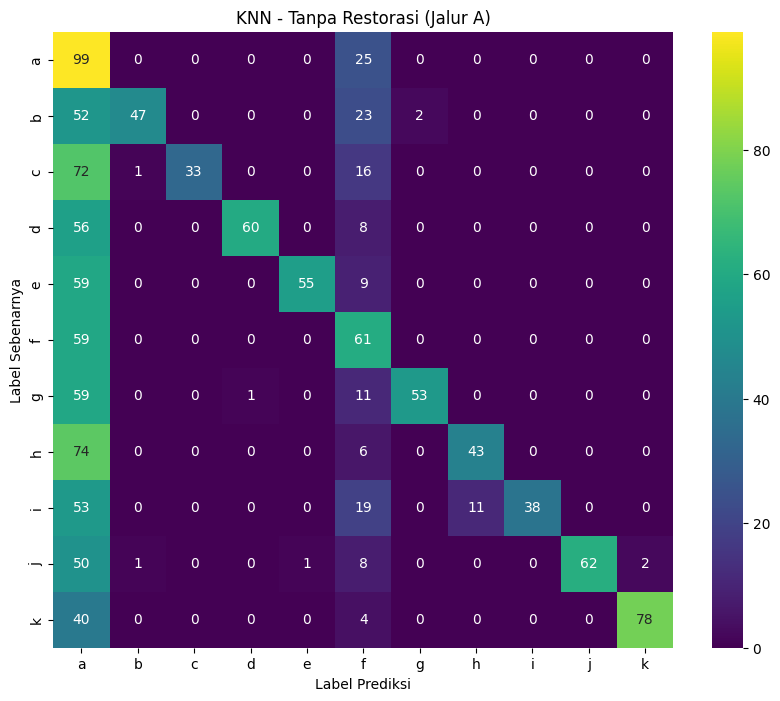



===== KNN - Dengan Restorasi (Jalur B) =====
              precision    recall  f1-score   support

           a       0.57      0.88      0.69       124
           b       0.82      0.57      0.67       124
           c       0.95      0.16      0.28       122
           d       0.83      0.82      0.83       124
           e       0.92      0.62      0.74       123
           f       0.26      0.96      0.41       120
           g       0.82      0.56      0.66       124
           h       0.64      0.44      0.52       123
           i       0.89      0.39      0.54       121
           j       1.00      0.59      0.74       124
           k       0.88      0.83      0.85       122

    accuracy                           0.62      1351
   macro avg       0.78      0.62      0.63      1351
weighted avg       0.78      0.62      0.63      1351



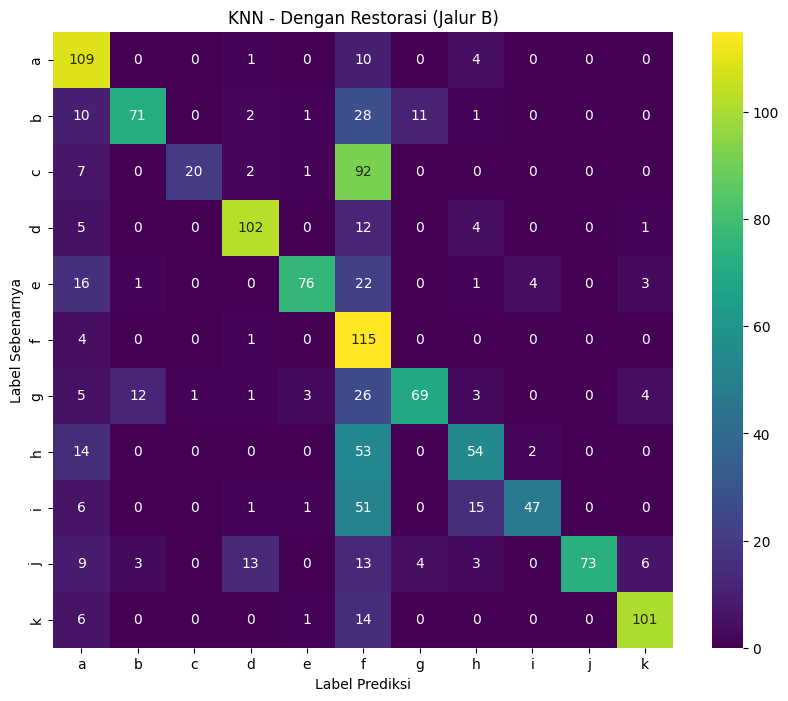



===== SVM - Tanpa Restorasi (Jalur A) =====
              precision    recall  f1-score   support

           a       0.18      1.00      0.31       124
           b       0.94      0.37      0.53       124
           c       1.00      0.30      0.47       122
           d       1.00      0.47      0.64       124
           e       1.00      0.41      0.58       123
           f       0.54      0.39      0.45       120
           g       0.51      0.58      0.54       124
           h       0.77      0.38      0.51       123
           i       1.00      0.34      0.51       121
           j       1.00      0.55      0.71       124
           k       1.00      0.62      0.77       122

    accuracy                           0.49      1351
   macro avg       0.81      0.49      0.55      1351
weighted avg       0.81      0.49      0.55      1351



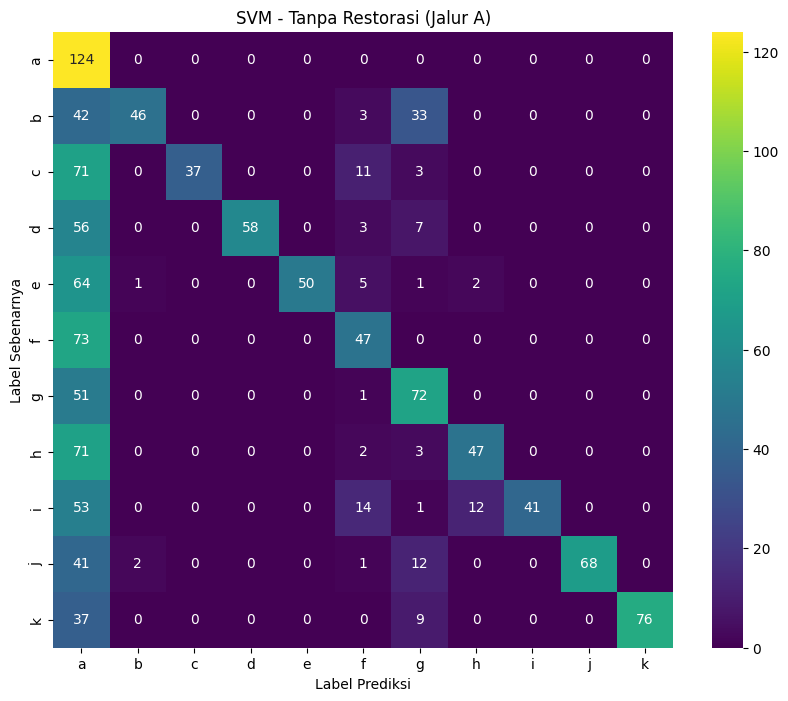



===== SVM - Dengan Restorasi (Jalur B) =====
              precision    recall  f1-score   support

           a       0.44      0.93      0.59       124
           b       0.75      0.52      0.62       124
           c       0.97      0.23      0.37       122
           d       0.94      0.73      0.82       124
           e       0.95      0.50      0.65       123
           f       0.35      0.81      0.49       120
           g       0.48      0.78      0.60       124
           h       0.70      0.49      0.57       123
           i       0.94      0.40      0.57       121
           j       0.95      0.71      0.81       124
           k       0.96      0.80      0.87       122

    accuracy                           0.63      1351
   macro avg       0.77      0.63      0.63      1351
weighted avg       0.77      0.63      0.63      1351



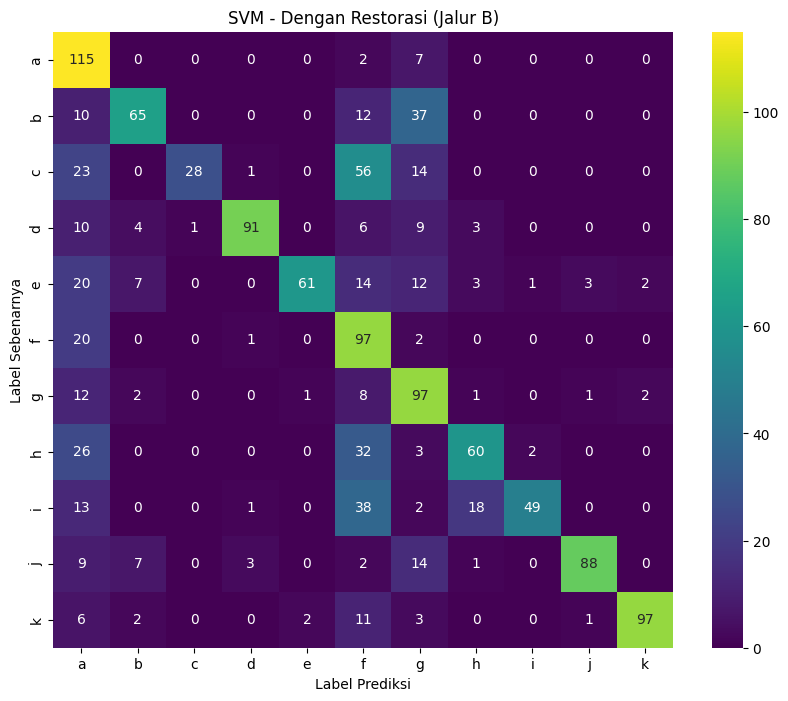



===== Cosine Similarity - Tanpa Restorasi (Jalur A) =====
              precision    recall  f1-score   support

           a       0.19      1.00      0.32       124
           b       0.92      0.49      0.64       124
           c       0.92      0.39      0.54       122
           d       1.00      0.55      0.71       124
           e       0.98      0.44      0.61       123
           f       0.93      0.33      0.48       120
           g       0.58      0.63      0.60       124
           h       0.86      0.41      0.55       123
           i       1.00      0.45      0.62       121
           j       0.92      0.69      0.79       124
           k       1.00      0.69      0.82       122

    accuracy                           0.55      1351
   macro avg       0.85      0.55      0.61      1351
weighted avg       0.85      0.55      0.61      1351



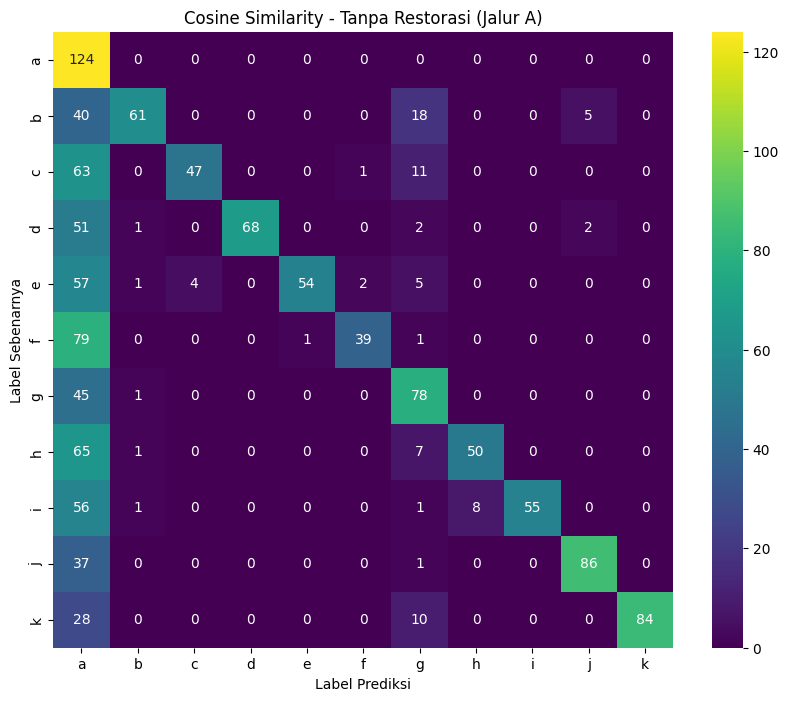



===== Cosine Similarity - Dengan Restorasi (Jalur B) =====
              precision    recall  f1-score   support

           a       0.38      0.90      0.53       124
           b       0.74      0.69      0.71       124
           c       0.75      0.52      0.61       122
           d       0.84      0.82      0.83       124
           e       0.93      0.57      0.71       123
           f       0.56      0.58      0.57       120
           g       0.64      0.68      0.66       124
           h       0.80      0.49      0.61       123
           i       0.81      0.50      0.62       121
           j       0.73      0.81      0.77       124
           k       0.85      0.80      0.82       122

    accuracy                           0.67      1351
   macro avg       0.73      0.67      0.68      1351
weighted avg       0.73      0.67      0.68      1351



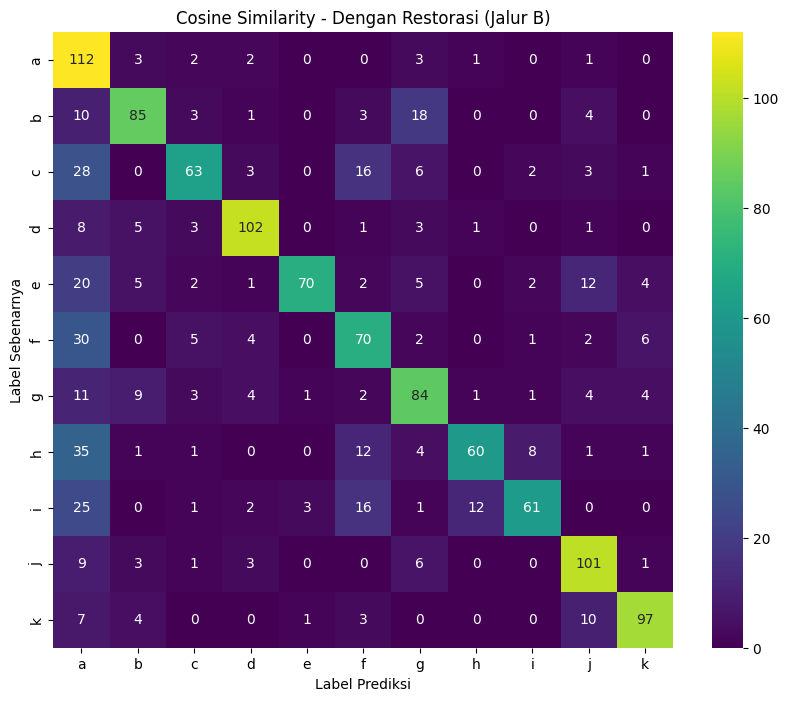

In [9]:
# ============== LANGKAH 5: ANALISIS HASIL ==============

df = pd.read_json(results_file_path)

# Pastikan tidak ada baris kosong yang menyebabkan error
df.dropna(subset=['ground_truth', 'prediction_A_knn', 'prediction_A_svm', 'prediction_A_cosine',
                   'prediction_B_knn', 'prediction_B_svm', 'prediction_B_cosine'], inplace=True)

labels = sorted(df['ground_truth'].unique())

def print_analysis(title, y_true, y_pred):
    print(f"===== {title} =====")
    print(classification_report(y_true, y_pred, labels=labels, zero_division=0))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('Label Sebenarnya')
    plt.xlabel('Label Prediksi')
    plt.show()
    print("\n" + "="*50 + "\n")

# Analisis untuk KNN
print_analysis("KNN - Tanpa Restorasi (Jalur A)", df['ground_truth'], df['prediction_A_knn'])
print_analysis("KNN - Dengan Restorasi (Jalur B)", df['ground_truth'], df['prediction_B_knn'])

# Analisis untuk SVM
print_analysis("SVM - Tanpa Restorasi (Jalur A)", df['ground_truth'], df['prediction_A_svm'])
print_analysis("SVM - Dengan Restorasi (Jalur B)", df['ground_truth'], df['prediction_B_svm'])

# Analisis untuk Cosine Similarity
print_analysis("Cosine Similarity - Tanpa Restorasi (Jalur A)", df['ground_truth'], df['prediction_A_cosine'])
print_analysis("Cosine Similarity - Dengan Restorasi (Jalur B)", df['ground_truth'], df['prediction_B_cosine'])

In [12]:
import pandas as pd
import json
import os
from sklearn.metrics import recall_score, f1_score

# ============== LANGKAH 1 (DIPERBAIKI): MUAT DAN PERSIAPKAN DATA ==============

RESULTS_FILE_PATH = os.path.join(RESULTS_PATH, 'pipeline_results_classifier.json')
try:
    df = pd.read_json(RESULTS_FILE_PATH)
    print(f"Berhasil memuat {len(df)} baris data dari {RESULTS_FILE_PATH}")
except FileNotFoundError:
    print(f"ERROR: File hasil tidak ditemukan di {RESULTS_FILE_PATH}.")
    df = pd.DataFrame()

# [PERBAIKAN] Ekstrak metadata LENGKAP dari kolom 'file', bukan dari 'metadata'
if not df.empty:
    # Definisikan fungsi parsing nama file di sini agar skrip mandiri
    def parse_filename_for_analysis(filename: str) -> dict | None:
        try:
            base_name = os.path.basename(filename)
            parts = os.path.splitext(base_name)[0].split('_')
            # Format diasumsikan: 'subject_X_height_Y_distance_Z.JPG'
            if len(parts) >= 5:
                height_id = parts[2]
                distance_id = parts[4]
                distance_m = 17 - (int(distance_id) / 2)
                height_m = 1.5 if height_id == "0" else int(height_id)
                return {'distance_m': distance_m, 'height_m': height_m}
            return None # Format nama file tidak sesuai
        except (IndexError, ValueError):
            return None # Error saat konversi tipe data

    # Terapkan fungsi parsing ke kolom 'file'
    extracted_metadata = df['file'].apply(parse_filename_for_analysis)

    # Buat kolom baru dari hasil parsing, tangani kasus None dengan aman
    df['distance_m'] = extracted_metadata.apply(lambda x: x.get('distance_m') if isinstance(x, dict) else None)
    df['height_m'] = extracted_metadata.apply(lambda x: x.get('height_m') if isinstance(x, dict) else None)
    
    if df['distance_m'].notna().any():
        print("Kolom 'distance_m' dan 'height_m' berhasil dibuat dari nama file.")
    else:
        print("Peringatan: Gagal mengekstrak data jarak/ketinggian dari nama file. Periksa format nama file Anda.")


# ============== LANGKAH 2: FUNGSI KALKULASI METRIK (Tidak Berubah) ==============

def calculate_metrics_for_scenario(dataframe, model_suffix, pipeline_suffix):
    is_correct_col = f'is_correct_{pipeline_suffix}_{model_suffix}'
    prediction_col = f'prediction_{pipeline_suffix}_{model_suffix}'
    cleaned_df = dataframe.dropna(subset=['ground_truth', is_correct_col, prediction_col])
    
    if cleaned_df.empty: return 0, 0, 0

    y_true = cleaned_df['ground_truth']
    y_pred = cleaned_df[prediction_col]
    
    accuracy = cleaned_df[is_correct_col].mean()
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    return accuracy, recall, f1


# ============== LANGKAH 3: DEFINISI SKENARIO (Tidak Berubah) ==============

if not df.empty and 'distance_m' in df.columns:
    scenarios = [
        {"name": "Jarak Dekat (< 7m)", "filter": df['distance_m'] < 7},
        {"name": "Jarak Menengah (7-12m)", "filter": (df['distance_m'] >= 7) & (df['distance_m'] < 12)},
        {"name": "Jarak Jauh (>= 12m)", "filter": df['distance_m'] >= 12},
        {"name": "Ketinggian 1.5m", "filter": df['height_m'] == 1.5},
        {"name": "Ketinggian 3m", "filter": df['height_m'] == 3},
        {"name": "Ketinggian 4m", "filter": df['height_m'] == 4},
        {"name": "Ketinggian 5m", "filter": df['height_m'] == 5},
    ]
else:
    scenarios = []


# ============== LANGKAH 4 (REVISI): PROSES SKENARIO UNTUK TABEL TERPISAH ==============

knn_results_data = []
svm_results_data = []
cosine_results_data = []

def process_and_store_results(dataframe, scenario_list):
    """Fungsi untuk memproses skenario dan menyimpan hasil ke list terpisah."""
    for scenario in scenario_list:
        scenario_name = scenario["name"]
        filtered_df = dataframe[scenario["filter"]] if "filter" in scenario else dataframe
        
        # Kalkulasi untuk KNN
        acc_A_knn, rec_A_knn, f1_A_knn = calculate_metrics_for_scenario(filtered_df, 'knn', 'A')
        acc_B_knn, rec_B_knn, f1_B_knn = calculate_metrics_for_scenario(filtered_df, 'knn', 'B')
        f1_imp_knn = ((f1_B_knn - f1_A_knn) / f1_A_knn) * 100 if f1_A_knn > 0 else float('inf')
        
        # Kalkulasi untuk SVM
        acc_A_svm, rec_A_svm, f1_A_svm = calculate_metrics_for_scenario(filtered_df, 'svm', 'A')
        acc_B_svm, rec_B_svm, f1_B_svm = calculate_metrics_for_scenario(filtered_df, 'svm', 'B')
        f1_imp_svm = ((f1_B_svm - f1_A_svm) / f1_A_svm) * 100 if f1_A_svm > 0 else float('inf')

        # Kalkulasi untuk Cosine
        acc_A_cosine, rec_A_cosine, f1_A_cosine = calculate_metrics_for_scenario(filtered_df, 'cosine', 'A')
        acc_B_cosine, rec_B_cosine, f1_B_cosine = calculate_metrics_for_scenario(filtered_df, 'cosine', 'B')
        f1_imp_cosine = ((f1_B_cosine - f1_A_cosine) / f1_A_cosine) * 100 if f1_A_cosine > 0 else float('inf')

        #===================

        # Simpan hasil ke list KNN
        knn_results_data.append([scenario_name, 'Tanpa Restorasi', f'{acc_A_knn:.2%}', f'{rec_A_knn:.2f}', f'{f1_A_knn:.2f}', ''])
        knn_results_data.append([scenario_name, 'Dengan Restorasi', f'{acc_B_knn:.2%}', f'{rec_B_knn:.2f}', f'{f1_B_knn:.2f}', f'{f1_imp_knn:.2f}%'])
        
        # Simpan hasil ke list SVM
        svm_results_data.append([scenario_name, 'Tanpa Restorasi', f'{acc_A_svm:.2%}', f'{rec_A_svm:.2f}', f'{f1_A_svm:.2f}', ''])
        svm_results_data.append([scenario_name, 'Dengan Restorasi', f'{acc_B_svm:.2%}', f'{rec_B_svm:.2f}', f'{f1_B_svm:.2f}', f'{f1_imp_svm:.2f}%'])

        # Simpan hasil ke list cosine
        cosine_results_data.append([scenario_name, 'Tanpa Restorasi', f'{acc_A_cosine:.2%}', f'{rec_A_cosine:.2f}', f'{f1_A_cosine:.2f}', ''])
        cosine_results_data.append([scenario_name, 'Dengan Restorasi', f'{acc_B_cosine:.2%}', f'{rec_B_cosine:.2f}', f'{f1_B_cosine:.2f}', f'{f1_imp_cosine:.2f}%'])

if not df.empty and scenarios:
    process_and_store_results(df, scenarios)
    process_and_store_results(df, [{"name": "Semua Data Uji"}]) # Proses untuk keseluruhan data


# ============== LANGKAH 5 (REVISI): TAMPILKAN DUA TABEL TERPISAH ==============

columns = ['Skenario', 'Metode', 'Akurasi (Top-1)', 'Recall', 'F1-Score', 'Peningkatan F1-Score (%)']

# --- Tampilkan Tabel KNN ---
if knn_results_data:
    knn_table = pd.DataFrame(knn_results_data, columns=columns)
    print("\n" + "="*120)
    print("Tabel Perbandingan Kinerja Pipeline - Model KNN".center(120))
    print("="*120)
    print(knn_table.to_string(index=False))
    print("="*120)
else:
    print("\nTidak dapat menghasilkan tabel untuk KNN.")

# --- Tampilkan Tabel SVM ---
if svm_results_data:
    svm_table = pd.DataFrame(svm_results_data, columns=columns)
    print("\n" + "="*120)
    print("Tabel Perbandingan Kinerja Pipeline - Model SVM".center(120))
    print("="*120)
    print(svm_table.to_string(index=False))
    print("="*120)
else:
    print("\nTidak dapat menghasilkan tabel untuk SVM.")

# --- Tampilkan Tabel Cosine ---
if cosine_results_data:
    cosine_table = pd.DataFrame(cosine_results_data, columns=columns)
    print("\n" + "="*120)
    print("Tabel Perbandingan Kinerja Pipeline - Model Cosine".center(120))
    print("="*120)
    print(cosine_table.to_string(index=False))
    print("="*120)
else:
    print("\nTidak dapat menghasilkan tabel untuk SVM.")

Berhasil memuat 1364 baris data dari d:\UNSRI_DATA\_SKRIPSI\PROGRAM\v1\pipeline_skripsi\results_v6.3_classifier\pipeline_results_classifier.json
Kolom 'distance_m' dan 'height_m' berhasil dibuat dari nama file.

                                    Tabel Perbandingan Kinerja Pipeline - Model KNN                                     
              Skenario           Metode Akurasi (Top-1) Recall F1-Score Peningkatan F1-Score (%)
    Jarak Dekat (< 7m)  Tanpa Restorasi          83.87%   0.84     0.85                         
    Jarak Dekat (< 7m) Dengan Restorasi          77.50%   0.78     0.79                   -6.94%
Jarak Menengah (7-12m)  Tanpa Restorasi          49.66%   0.50     0.54                         
Jarak Menengah (7-12m) Dengan Restorasi          68.64%   0.69     0.68                   25.09%
   Jarak Jauh (>= 12m)  Tanpa Restorasi           9.83%   0.10     0.05                         
   Jarak Jauh (>= 12m) Dengan Restorasi          41.12%   0.41     0.40              